In [27]:
%pylab inline
import time
import scanpy.api as sc
import pandas as pd
import seaborn as sns
from scipy.io import loadmat
sns.set_context('talk', font_scale=2)

from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

Populating the interactive namespace from numpy and matplotlib


In [33]:
import time
import scanpy
import pandas as pd
import seaborn as sns
sns.set_context('talk', font_scale=2)
from numpy import linalg as LA
from scipy.linalg import eigh

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import eigs
from scipy.io import loadmat

from sklearn.manifold import MDS
from sklearn.cluster import SpectralClustering

from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import euclidean_distances

In [31]:
def do_clustering(X, d, radius, n_clusters=2, plot_centers=False):
    nbrs = NearestNeighbors(radius=radius, algorithm='ball_tree').fit(X)
    distances, X_neighbors = nbrs.radius_neighbors(X)
    point_indices_master = pd.Series(range(X.shape[0]))
    

    # Step 0. Pick point y1 from data. pick y2 from data not in the neighborhood of y1. Pick y3 not in neighborhood of y1 and y2
    # Keep doing till n0 centers are found
    y_n0_centers = []
    while len(point_indices_master)>0:
        y = np.random.choice(point_indices_master, 1)[0]
        y_n0_centers.append(y)
        
        # Generate neighbors
        y_neighbors = X_neighbors[y]
        y_neighbors = y_neighbors[y_neighbors!=y]
        # Drop picked center from being picked up ever later
        point_indices_master.drop(y, inplace=True)
        # Drop picked center's neighbors
        point_indices_master.drop(y_neighbors, inplace=True, errors='ignore')
    print('N_nets: {}'.format(len(y_n0_centers)))
    # Step 1 for each i=1..mo0, calculate the sample covariance matrix C1 of neirhborhood of yi
    covariances = []
    #print(y_n0_centers)
    for center in y_n0_centers:
        #cov = np.cov(X[X_neighbors[center]].T)
        neighbor_matrix = X[X_neighbors[center]]
        #print(neighbor_matrix.shape)
        center_mean = neighbor_matrix.mean(axis=0)
        Y = np.matlib.repmat(center_mean, neighbor_matrix.shape[0], 1)
        cov  = np.dot(Y.T, Y)/(Y.shape[0]-1)        
        covariances.append(cov)
    
    Q = []
    center_means = []
    for cov in covariances:
        
        #eig_values, eig_matrix = eigh(cov, eigvals=range(d))
        #Q.append(eig_matrix[:, :d])
        U, s, V = LA.svd(cov)
        Q.append(np.dot(U[:, :d], U[:, :d].T))
    
    #print(Q[0])
    
    for center in y_n0_centers:
        center_means.append(X[X_neighbors[center]].mean(axis=0))
    
    A = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    B = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    for i in range(len(y_n0_centers)):
        for j in range(len(y_n0_centers)):
            A[i, j] = LA.norm(center_means[i]-center_means[j], 2)
            #B[i, j] = LA.norm(covariances[i]-covariances[j], 2)
            B[i, j] = LA.norm(Q[i]-Q[j], 2)
            
    C = np.ones(A.shape)
    
    min_A = np.min(np.min(A+(10**3)* np.eye(A.shape[0])))
    max_A = np.max(np.max(A))
    
    
    
    
    min_B = np.min(np.min(B+(10**3)* np.eye(B.shape[0])))
    max_B = np.max(np.max(B))
    
    #step_A = (np.log(max_A) - np.log(min_A))/10
    #step_B = (np.log(max_B) - np.log(min_B))/10
    
    
    #sigma_A = np.exp(np.arange(-10, 10, 1)*step_A + np.log(min_A))
    #sigma_B = np.exp(np.arange(-2,10, 0.4)*step_B + np.log(min_B))
    
    connected_A = np.max(np.min(A+100*np.eye(A.shape[0])))
    
    connected_graph = A<connected_A
    connected_graph = connected_graph.astype(int) - np.diag(np.diag(connected_graph))
    #print(np.sum(connected_graph))
    if np.sum(connected_graph) > 0:
        print('yes')
    eta = 0.05# min_A#0.05
    eps = 0.05 # max_A#0.05
    print(min_A, max_A, min_B, max_B)
    #print(min_B)

    #print(len(sigma_A))
    #print(len(sigma_B))
        
    # W = np.zeros((len(y_n0_centers), len(y_n0_centers)))
    #for i in range(W.shape[0]):
    #    for j in range(W.shape[0]):
            #projection_i =  np.dot(X_neighbors[y_n0_centers[i]], Q[i])
            #projection_j =  np.dot(X_neighbors[y_n0_centers[j]], Q[j])
            #W[i, j] = np.exp(-LA.norm(X[y_n0_centers[i]]-X[y_n0_centers[j]], 2)**2/epsilon**2) * np.exp(-LA.norm(projection_i-projection_j, 2)**2/eta**2)
    W = np.exp(-np.power(A, 2)/eps**2) * np.exp(-np.power(B, 2)/eta**2)
    # print(W.shape)
    clustering = SpectralClustering(n_clusters=n_clusters,
                                    assign_labels="kmeans",
                                    affinity='precomputed',
                                    random_state=0).fit(W)


    centers = X[y_n0_centers]

    # For each point, calculate the distance from all 4 vectors and find the minimum
    distances = euclidean_distances(X, centers)
    min_distance_centers = np.argmin(distances, axis=1)
    color_indices = pd.Series(clustering.labels_)[min_distance_centers]
    return color_indices

In [40]:
def compare_algorithms(dataset):    
    colors = pd.Series(sns.color_palette('Paired'))

    clustering_names = [
    'MiniBatchKMeans', 'AffinityPropagation', 'MeanShift',
    'SpectralClustering', 'Ward', 'AgglomerativeClustering',
    'DBSCAN', 'Birch']

    plt.figure(figsize=(len(clustering_names) * 2 + 3, 9.5))
    plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                        hspace=.01)

    plot_num = 1
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=1000, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=2)
    ward = cluster.AgglomerativeClustering(n_clusters=2, linkage='ward',
                                           connectivity=connectivity)
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)
    affinity_propagation = cluster.AffinityPropagation(damping=.9,
                                                       preference=-200)

    average_linkage = cluster.AgglomerativeClustering(
        linkage="average", affinity="cityblock", n_clusters=2,
        connectivity=connectivity)

    birch = cluster.Birch(n_clusters=2)
    clustering_algorithms = [
        two_means, affinity_propagation, ms, spectral, ward, average_linkage,
        dbscan, birch]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        t0 = time.time()
        algorithm.fit(X)
        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10, alpha=0.4)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors, alpha=0.4)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

In [41]:
d = 1
radius = 0.01

#data = loadmat('../local-pca-code-matlab/threecurves.mat')
data = loadmat('../local-pca-code-matlab/twocurves1.mat')
Y = data['Y']
labels = do_clustering(Y, d, radius, 2)


N_nets: 93
0.0018102173861150991 0.5798913511488266 8.096100054334528e-05 0.8806929633979811


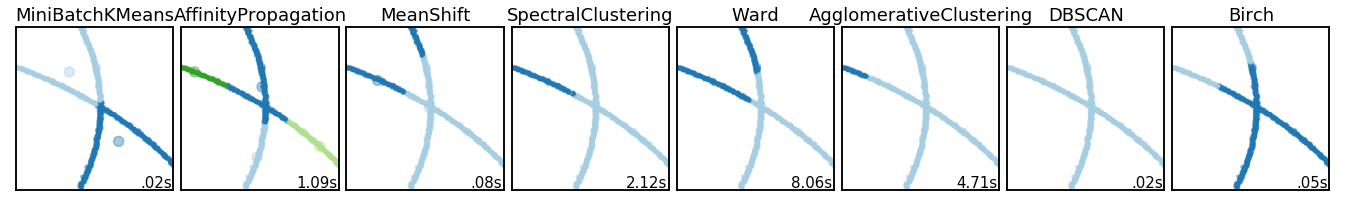

In [42]:
compare_algorithms((Y, labels))

In [30]:
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'X', 'Y', 'M', 'alltheta'])


In [5]:
data_matrix1 = np.load('../data/Test_1_mECS_matrix.npy')
data_labels1 = np.load('../data/Test_1_mECS_labels.npy')
                      

In [16]:
adata = sc.read ('../data/Test_1_mECS_anndata.h5ad')

In [17]:
sc.pp.pca(df)

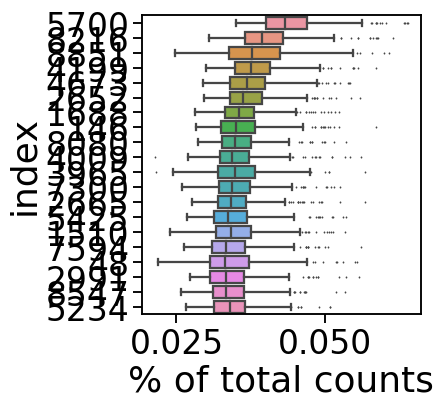

In [18]:
sc.pl.highest_expr_genes(adata, n_top=20)


In [19]:
sc.tl.pca(adata, svd_solver='arpack')


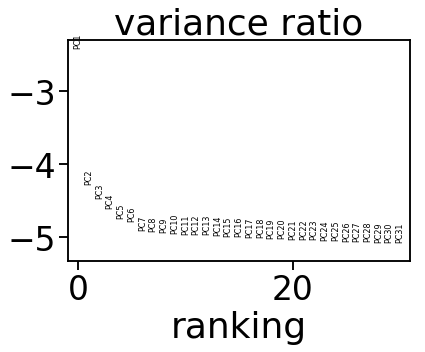

In [20]:
sc.pl.pca_variance_ratio(adata, log=True)


In [23]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)

sc.tl.umap(adata)


In [24]:
sc.tl.louvain(adata)


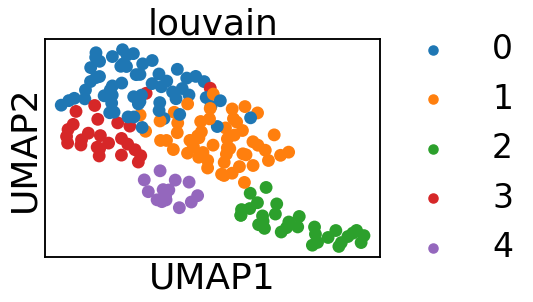

In [26]:
sc.pl.umap(adata, color=['louvain'])
